# Parallel stochastic simulation

Stochastic simulation is an [embarrassingly parallel problem](https://en.wikipedia.org/wiki/Embarrassingly_parallel) in which realizations are only a function of the random seed, and can be generated indenpendently one from another. Although this is a well-known fact, there has not been reasonable effort in geostatistical software to exploit modern hardware such as HPC clusters and the cloud (e.g. AWS, MS Azure).

In GeoStats.jl, *all* stochastic simulation algorithms generate realizations in parallel by default. The package exploits Julia's built-in support for parallel execution, and works seamlessly on personal laptops with multiple cores as well as on high-performance computer clusters with multiple nodes.

In this tutorial, we demonstrate how to generate realizations with sequential Gaussian simulation in parallel. The same script can be run on a computer cluster where thousands of processes are available.

## Parallel setup

When you start Julia, it starts with a single process:

In [1]:
using Distributed

nprocs()

1

In order to run simulations in parallel, the first thing we need to do is increase the number of processes in the pool *before* loading the environment. The command `addprocs` adds a given number of processes for parallel execution:

In [2]:
addprocs(topology=:master_worker)

8-element Array{Int64,1}:
 2
 3
 4
 5
 6
 7
 8
 9

Notice that `addprocs()` when called without an argument, adds the number of *logical* cores available in the machine. The `topology` option specifies the type of communication allowed, in this case only the master process can communicate with workers.

> **WARNING:** If you are on Windows 8 or an older version of the operating system, you will likely experience a slow down. Please add the number of *physical* cores instead that can be found externally in computer settings or via packages such as [CpuId.jl](https://github.com/m-j-w/CpuId.jl) and [Hwloc.jl](https://github.com/JuliaParallel/Hwloc.jl).

On a HPC cluster, computing resources are generally requested via a resource manager (e.g. SLURM, PBS). In this case, the package [ClusterManagers.jl](https://github.com/JuliaParallel/ClusterManagers.jl) provides variants of the built-in `addprocs()` for adding processes to the pool effortlessly. For example, we can use `addprocs_slurm(1000)` to request 1000 processes in a SLURM job.

Now that the processes are available, we can instantiate the environment in all processes:

In [3]:
@everywhere begin
    using Pkg
    push!(empty!(LOAD_PATH), @__DIR__)
    Pkg.instantiate()
    
    # make sure results are reproducible
    using Random; Random.seed!(myid())
end

## Problem definition

We define a simulation problem with 30 realizations of `facies` and `porosity` over a 100x100 grid:

In [4]:
using GeoStats

problem = SimulationProblem(RegularGrid{Float64}(100,100), (:facies=>Int, :porosity=>Float64), 30)

2D SimulationProblem (unconditional)
  domain:    100×100 RegularGrid{Float64,2}
  variables: porosity (Float64) and facies (Int64)
  N° reals:  30

## Solving the problem

We simulate `facies` with image quilting, and then for each facies type (0 or 1), we specify a different variogram model for `porosity`:

In [5]:
using GeoStatsImages
using ImageQuilting
using DirectGaussianSimulation

TI = training_image("Ellipsoids")[:,:,1]

fsolver = ImgQuilt(:facies => (TI=TI, tilesize=(30,30)))

psolver₀ = DirectGaussSim(
    :porosity => (variogram=SphericalVariogram(range=20., sill=.2),)
)

psolver₁ = DirectGaussSim(
    :porosity => (variogram=SphericalVariogram(range=20., distance=Ellipsoidal([10.,1.],[0.])),)
)

solver = CookieCutter(fsolver, [0 => psolver₀, 1 => psolver₁])

CookieCutter
  └─facies ⇨ ImgQuilt
    └─0 ⇨ DirectGaussSim
    └─1 ⇨ DirectGaussSim


In [6]:
solution = solve(problem, solver)

2D SimulationSolution
  domain: 100×100 RegularGrid{Float64,2}
  variables: porosity and facies
  N° reals:  30

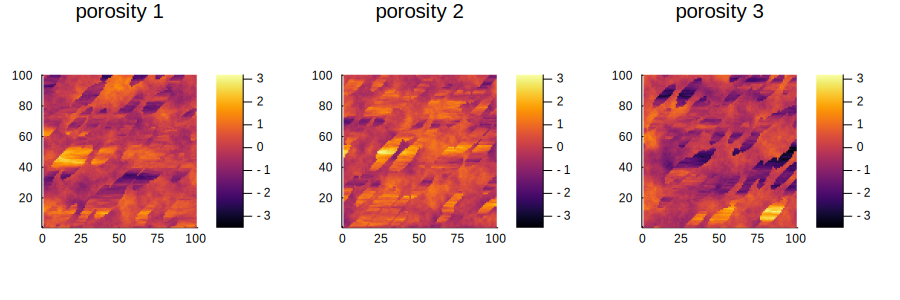

In [7]:
using Plots

plot(solution, variables=[:porosity], c=:inferno, size=(900,300))

## Remarks

- Users can utilize hardware resources such as HPC clusters and the cloud to speed up simulation jobs. In theory, the speedup is upper bounded by the number of computing nodes/cores/processes available. In practice, this translates into generating multiple realizations within the time required for one.
- On a personal laptop or desktop, serial (non-parallel) simulation can often outperform parallel simulation.